#  Import packages

In [1]:
import numpy as np
import h5py
import glob
import re
import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from scipy.stats import pearsonr

np.set_printoptions(precision=3, suppress=True)

2024-02-18 20:04:04.238481: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-18 20:04:04.238515: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-18 20:04:04.267987: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-18 20:04:04.316355: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Setup GPU

First, follow instructions [here](https://gist.github.com/zrruziev/b93e1292bf2ee39284f834ec7397ee9f), or alternatively run:
```bash
for a in /sys/bus/pci/devices/*; do echo 0 | sudo tee -a $a/numa_node; done
```
We do this as a workaround for [this error](https://github.com/tensorflow/tensorflow/issues/42738):

In [2]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)
print(tf.config.list_physical_devices('GPU'), tf.test.gpu_device_name())

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')] /device:GPU:0


2024-02-18 20:04:07.853923: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /device:GPU:0 with 4115 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2060, pci bus id: 0000:07:00.0, compute capability: 7.5


# Import and prepare data

In [3]:
def extract_floats(string):
    return re.findall(r"[-+]?\d*\.\d+|\d+", string)

def data_load(alphas,densities):
    files = []
    for alp in alphas:
        for val in densities:
            files += glob.glob(f"../augmented_data/dataset_tumble_{alp}_{val}.h5")
    inputs,outputs = [],[]
    for f in files:
        tumble = float(extract_floats(f)[0])
        with h5py.File(f, "r") as fin:
          count = 0
          for key in fin.keys():
              img = fin[key][:]
              img[img > 0] = 1 
              img = img.reshape((img.shape[0], img.shape[1],1))
              shape = img.shape
              inputs.append(img)
              outputs.append(tumble)
              count+=1

    # Scramble the dataset
    order = np.arange(len(outputs)).astype(int)
    order = np.random.permutation(order)
    return np.array(inputs)[order],np.array(outputs)[order],shape

In [4]:
def split_dataset(x,y,last=2000):
    print("Number of unique alpha: ", len(np.unique(y)))
    print("Shape of x: ", np.shape(x))
    print("Shape of y: ", np.shape(y))

    x_train, y_train = x[:-last], y[:-last]
    x_val,y_val = x[-last:],y[-last:]

    print("Size of training data: ", len(x_train))
    print("Size of validation data: ", len(x_val))
    return x_train, y_train, x_val, y_val

In [5]:
x,y,shape = data_load(alphas=[0.023,0.157], densities=[0.2])

We have N * number of unique alpha snapshots total, we split them into training set and a validation set with the ratio 80/20:

In [6]:
x_train, y_train, x_val, y_val = split_dataset(x,y,last=int(len(x)*0.2))

Number of unique alpha:  2
Shape of x:  (16000, 128, 128, 1)
Shape of y:  (16000,)
Size of training data:  12800
Size of validation data:  3200


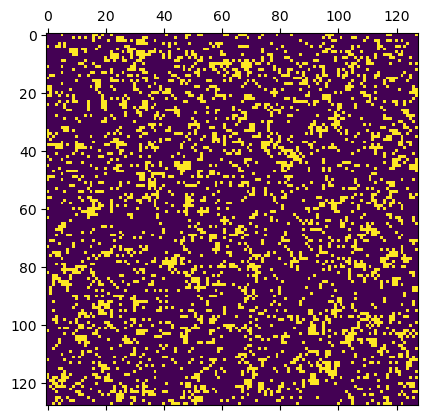

In [7]:
plt.matshow(x_val[1000])

# Setup and train our model

In [8]:
from tensorflow import keras
from keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Conv2D,Flatten,Dropout,MaxPooling2D,BatchNormalization,AveragePooling2D,Normalization,LeakyReLU,GlobalAveragePooling2D,ReLU

Workaround for dropout not working:

In [10]:
import contextlib

@contextlib.contextmanager
def options(options):
  old_opts = tf.config.optimizer.get_experimental_options()
  tf.config.optimizer.set_experimental_options(options)
  try:
    yield
  finally:
    tf.config.optimizer.set_experimental_options(old_opts)

**Run this after analysis to reset model and release RAM before changing the architecture**

In [399]:
import gc

K.clear_session()
del prediction
del model
del history

print("Collected: ", gc.collect())

Collected:  4105


## Setting up the model's architecture

In [11]:
def make_net(shape):
    model = Sequential()
    
    model.add(Conv2D(filters=3, kernel_size=(3, 3), padding="same", activation="relu", input_shape=shape))
    model.add(BatchNormalization())
    model.add(Conv2D(filters=3, kernel_size=(3, 3), padding="same"))
    model.add(BatchNormalization())
    #model.add(ReLU())
    
    model.add(MaxPooling2D(pool_size=(2, 2), padding="same"))
    
    #model.add(Conv2D(filters=6, kernel_size=(3, 3), padding="same"))
    #model.add(Conv2D(filters=6, kernel_size=(3, 3), padding="same"))
    #model.add(MaxPooling2D(pool_size=(2, 2), padding="same"))
    
    #model.add(Conv2D(filters=9, kernel_size=(5, 5), padding="same"))
    #model.add(MaxPooling2D(pool_size=(2, 2), padding="same"))
    #model.add(ReLU())
    #model.add(BatchNormalization())
    
    #model.add(GlobalAveragePooling2D())
    
    #with options({"layout_optimizer": False}):
    #    model.add(Dropout(0.1))
    
    #model.add(Dense(units=128, activation="relu"))
    
    #with options({"layout_optimizer": False}):
    #    model.add(Dropout(0.1))
        
    model.add(Dense(units=3, activation="relu"))
    
    model.add(Flatten())
    model.add(Dense(units=1, activation="linear"))
    return model

In [12]:
model = make_net(shape)

2024-02-18 20:04:26.933022: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4115 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2060, pci bus id: 0000:07:00.0, compute capability: 7.5
2024-02-18 20:04:26.933107: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


## Optimizer

In [13]:
#optimizer = keras.optimizers.Adam(learning_rate=0.0003)
optimizer = keras.optimizers.SGD(learning_rate=0.005)
model.compile(loss='mae', optimizer=optimizer, metrics=['mae'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 3)       30        
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 3)      12        
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 3)       84        
                                                                 
 batch_normalization_1 (Batc  (None, 128, 128, 3)      12        
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 3)        0         
 )                                                               
                                                        

## Training and evaluation

Before training, these are the "predictions":

94/94 [==============================] - 0s 3ms/step
Shape of prediction :  (6000, 1)
Pearson's correlation coeff:  nan


/tmp/ipykernel_260222/3900717829.py:7: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  print("Pearson's correlation coeff: ", pearsonr(y_val, prediction.T[0]).statistic)


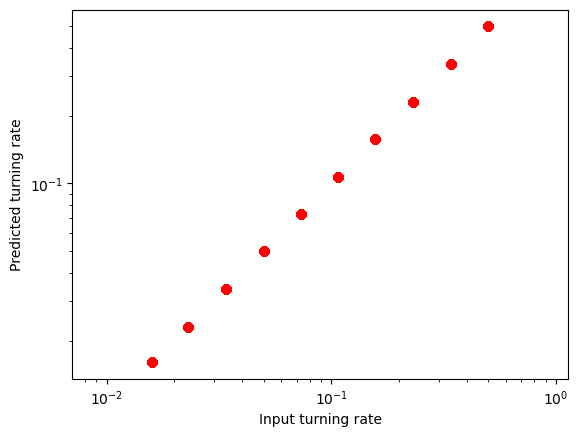

In [21]:
prediction = model.predict(x_val, batch_size=64)
print("Shape of prediction : ", np.shape(prediction))

plt.plot(y_val, prediction.T[0], 'o', c='k', alpha=0.25)
plt.plot(y_val, y_val, 'o', color='r')

print("Pearson's correlation coeff: ", pearsonr(y_val, prediction.T[0]).statistic)
plt.xlabel("Input turning rate")
plt.ylabel("Predicted turning rate")
plt.axis("equal")
plt.xscale("log")
plt.yscale("log")

Actual:  0.157
Predicted:  0.0


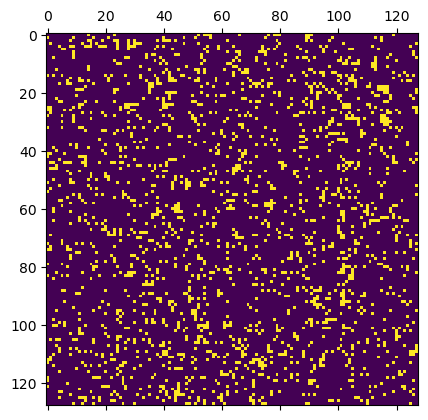

In [22]:
demo_idx = 100
plt.matshow(x_val[demo_idx])
print("Actual: ", y_val[demo_idx])
print("Predicted: ", prediction.T[0][demo_idx])

We can play with the architecture and see how the untrained predictions can change too.

## Run the training

In [14]:
epochs=30
batch_size=64
history = model.fit(
    x_train,
    y_train,
    epochs=epochs,
    verbose=True,
    batch_size=batch_size,
    validation_data=(x_val, y_val)
)

Epoch 1/30


2024-02-18 20:04:36.838882: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
2024-02-18 20:04:37.574323: I external/local_xla/xla/service/service.cc:168] XLA service 0x784abc7fbd10 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-02-18 20:04:37.574349: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 2060, Compute Capability 7.5
I0000 00:00:1708286677.660942  286493 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


200/200 [==============================] - 4s 11ms/step - loss: 0.5633 - mae: 0.5633 - val_loss: 0.0963 - val_mae: 0.0963
Epoch 2/30
200/200 [==============================] - 2s 10ms/step - loss: 0.0680 - mae: 0.0680 - val_loss: 0.0716 - val_mae: 0.0716
Epoch 3/30
200/200 [==============================] - 2s 10ms/step - loss: 0.0387 - mae: 0.0387 - val_loss: 0.0363 - val_mae: 0.0363
Epoch 4/30
200/200 [==============================] - 2s 10ms/step - loss: 0.0278 - mae: 0.0278 - val_loss: 0.0276 - val_mae: 0.0276
Epoch 5/30
200/200 [==============================] - 2s 10ms/step - loss: 0.0225 - mae: 0.0225 - val_loss: 0.0231 - val_mae: 0.0231
Epoch 6/30
200/200 [==============================] - 2s 10ms/step - loss: 0.0196 - mae: 0.0196 - val_loss: 0.0205 - val_mae: 0.0205
Epoch 7/30
200/200 [==============================] - 2s 10ms/step - loss: 0.0179 - mae: 0.0179 - val_loss: 0.0188 - val_mae: 0.0188
Epoch 8/30
200/200 [==============================] - 2s 10ms/step - loss: 0.016

In [15]:
print("Evaluate on test data:")
results = model.evaluate(x_val, y_val, batch_size=batch_size, verbose=0)
print("Test loss:", results)

Evaluate on test data:
Test loss: [0.011750005185604095, 0.011750005185604095]


# Alternatively, load a trained model

In [196]:
name = "implement6908"
model = tf.keras.models.load_model(f'../models/{name}.keras')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 3)       30        
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 3)        0         
 )                                                               
                                                                 
 re_lu (ReLU)                (None, 64, 64, 3)         0         
                                                                 
 batch_normalization (BatchN  (None, 64, 64, 3)        12        
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 6)         294       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 6)        0

# Analyse training results

In [16]:
prediction = model.predict(x_val)
print("Shape of prediction : ", np.shape(prediction))

100/100 [==============================] - 0s 2ms/step
Shape of prediction :  (3200, 1)


Text(0, 0.5, 'Predicted turning rate')

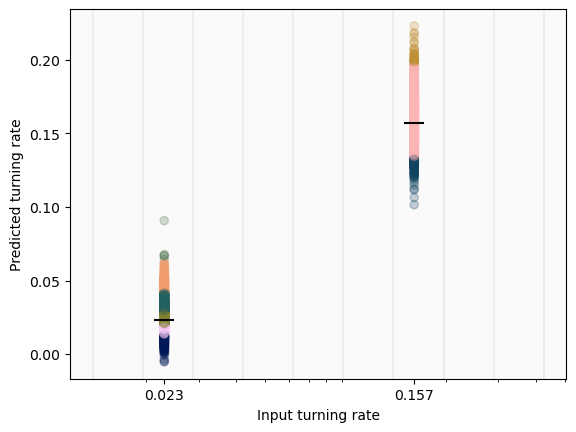

In [17]:
from cmcrameri import cm

bins = np.logspace(-6,-1,10, base=2)*0.85

v = prediction.T[0]

colors = cm.batlowS(np.digitize(v, bins))
colors_actual = cm.batlowS(np.digitize(np.unique(y_val),bins))

fig, ax = plt.subplots()
ax.scatter(y_val, v, c=colors, alpha=0.25)
ax.scatter(np.unique(y_val), np.unique(y_val), marker="_", color='k', s=200)

ax.set_xscale("log")
ax.get_xaxis().set_major_formatter(ticker.ScalarFormatter())
ax.set_xticks(np.unique(y_val))

#ax.set_yscale("log")
#ax.get_yaxis().set_major_formatter(ticker.ScalarFormatter())
#ax.set_yticks(np.unique(y_val))

ax.set_facecolor([0.98,0.98,0.98,1])

for val in bins:
    ax.axvline(val, alpha=0.05, c='k')

ax.set_xlabel("Input turning rate")
ax.set_ylabel("Predicted turning rate")

In [18]:
std = []
overlap = []
accuracy = 1e-4
for val in np.unique(y_val):
    v_mapped = v[np.where(y_val == val)]
    std.append(np.std(v_mapped))
    overlap.append((val + accuracy >= np.min(v_mapped)) & (val - accuracy <= np.max(v_mapped)))

print("Overlap ratio:", np.sum(overlap)/len(overlap))
print("(Min, Max, Avg) STD:", np.min(std), np.max(std), np.mean(std))
print("Pearson's correlation coeff: ", pearsonr(y_val, v).statistic)

Overlap ratio: 1.0
(Min, Max, Avg) STD: 0.011000638 0.017264768 0.014132703
Pearson's correlation coeff:  0.9769550046058834


Text(0.5, 1.0, 'Training and Validation MAE')

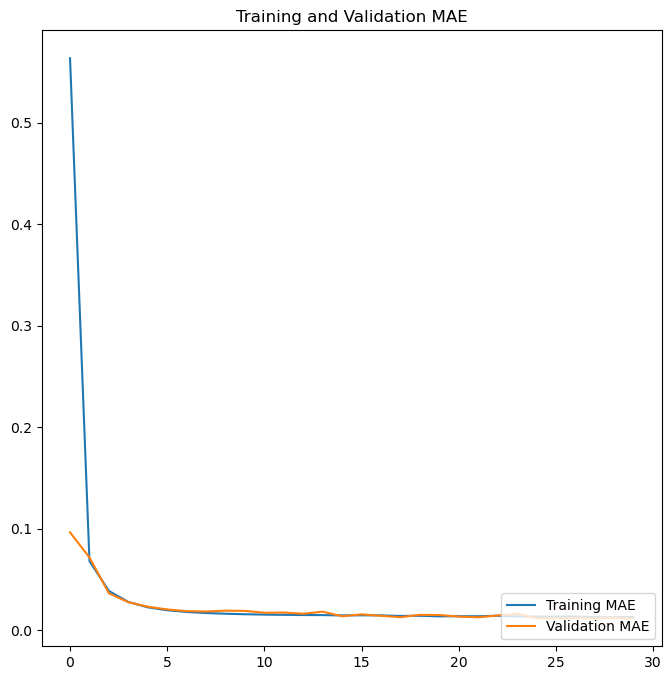

In [19]:
acc = history.history['mae']
val_acc = history.history['val_mae']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.plot(epochs_range, acc, label='Training MAE')
plt.plot(epochs_range, val_acc, label='Validation MAE')
plt.legend(loc='lower right')
plt.title('Training and Validation MAE')

### Kernel analysis

3


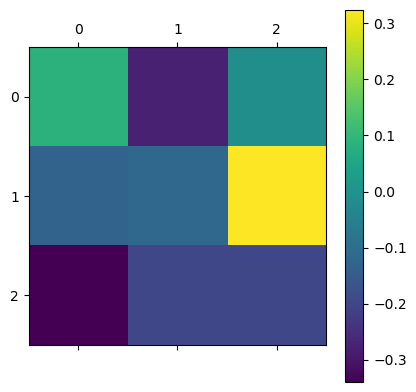

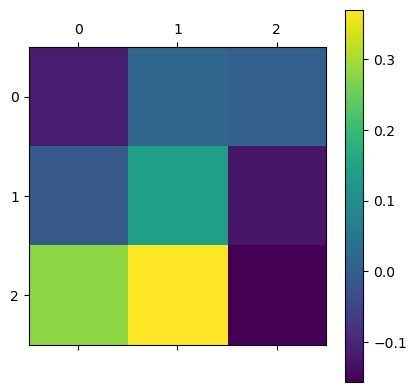

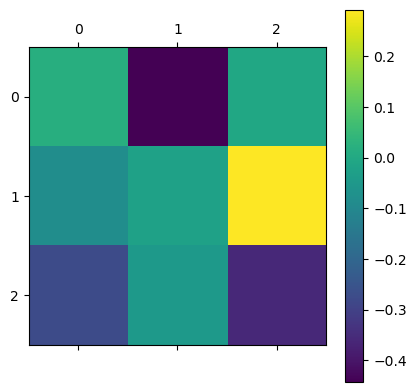

In [296]:
filters, biases = model.layers[0].get_weights()
print (filters.shape[-1])
for k in range(filters.shape[-1]):
  f = filters[:, :, :, k]
  plt.matshow(f.squeeze())
  plt.colorbar()

# Save model (if needed)

In [20]:
name = "astronaut1046"
model.save(f"../models/{name}.keras")